In [1]:
# Define the PSFAN model function
def PSFAN(input, num_classes):
    conv1 = Conv2D(32, (3, 3), dilation_rate=1, activation=LeakyReLU(alpha=0.02))(input)
    x = Conv2D(32, (1, 1), padding='same')(conv1)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a = Activation('sigmoid')(x)
    attention = Multiply()([a, conv1])
    add = Add()([x, attention])
    M = MaxPooling2D(pool_size=(3, 3), padding='valid')(add)
    F = Flatten()(M)

    conv2 = Conv2D(32, (3, 3), dilation_rate=2, activation=LeakyReLU(alpha=0.02))(conv1)
    x = Conv2D(32, (1, 1), padding='same')(conv2)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a1 = Activation('sigmoid')(x)
    attention1 = Multiply()([a1, conv2])
    add1 = Add()([x, attention1])
    M1 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add1)
    F1 = Flatten()(M1)

    conv3 = Conv2D(64, (3, 3), dilation_rate=3, activation=LeakyReLU(alpha=0.02))(conv2)
    x = Conv2D(64, (1, 1), padding='same')(conv3)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a2 = Activation('sigmoid')(x)
    attention2 = Multiply()([a2, conv3])
    add2 = Add()([x, attention2])
    M2 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add2)
    F2 = Flatten()(M2)

    conv4 = Conv2D(64, (3, 3), dilation_rate=4, activation=LeakyReLU(alpha=0.02))(conv3)
    x = Conv2D(64, (1, 1), padding='same')(conv4)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a3 = Activation('sigmoid')(x)
    attention3 = Multiply()([a3, conv4])
    add3 = Add()([x, attention3])
    M3 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add3)
    F3 = Flatten()(M3)

    C = Concatenate()([F, F1, F2, F3])

    D2 = Dense(128, activation=LeakyReLU(alpha=0.02))(C)
    D2 = Dense(64, activation=LeakyReLU(alpha=0.02))(D2)

    OUT = Dense(num_classes, activation='softmax')(D2)
    model = Model(inputs=[input], outputs=OUT, name="PSFANModel")
    return model


Training model for spectrogram type: stft
Epoch 1/50
13/13 [==============================] - 71s 5s/step - loss: 0.7407 - accuracy: 0.4643 - val_loss: 0.6994 - val_accuracy: 0.5102
Epoch 2/50
13/13 [==============================] - 62s 5s/step - loss: 0.6949 - accuracy: 0.5408 - val_loss: 0.6925 - val_accuracy: 0.5102
Epoch 3/50
13/13 [==============================] - 56s 4s/step - loss: 0.6534 - accuracy: 0.6735 - val_loss: 0.6982 - val_accuracy: 0.5306
Epoch 4/50
13/13 [==============================] - 53s 4s/step - loss: 0.6140 - accuracy: 0.6786 - val_loss: 0.7110 - val_accuracy: 0.4694
Epoch 5/50
13/13 [==============================] - 55s 4s/step - loss: 0.5691 - accuracy: 0.7041 - val_loss: 0.7743 - val_accuracy: 0.4898
Epoch 6/50
13/13 [==============================] - 54s 4s/step - loss: 0.4892 - accuracy: 0.8214 - val_loss: 0.7348 - val_accuracy: 0.4898
Epoch 7/50
2/2 [==============================] - 4s 1s/step
Fold 1 Results: Accuracy=51.02%, F1=0.51, Precision=0.52,

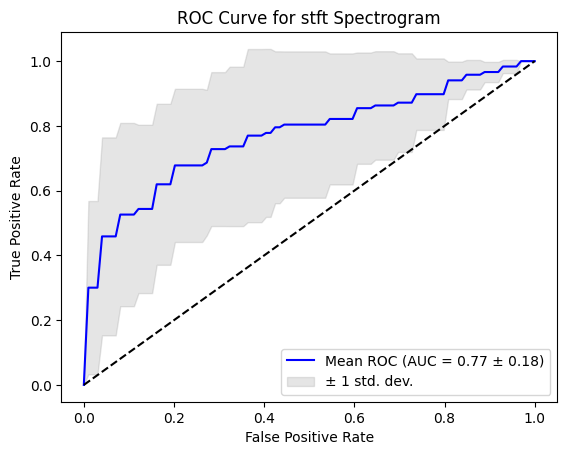


Mean and Std Dev of Performance Metrics for Spectrogram stft:
Fold                   3.000000
Accuracy              70.204082
F1 Score               0.699336
Precision              0.711273
Recall                 0.702041
Specificity            0.764308
Kappa                  0.403620
ROC AUC                0.771682
Training Time (s)    371.388766
Testing Time (s)      11.100548
dtype: float64
Fold                  1.581139
Accuracy             14.035713
F1 Score              0.140280
Precision             0.144741
Recall                0.140357
Specificity           0.191433
Kappa                 0.278550
ROC AUC               0.198487
Training Time (s)    48.173605
Testing Time (s)      9.471518
dtype: float64


In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, LeakyReLU, Multiply, Add, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['stft']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels


# Define the PSFAN model function
def PSFAN(input, num_classes):
    conv1 = Conv2D(32, (3, 3), dilation_rate=1, activation=LeakyReLU(alpha=0.02))(input)
    x = Conv2D(32, (1, 1), padding='same')(conv1)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a = Activation('sigmoid')(x)
    attention = Multiply()([a, conv1])
    add = Add()([x, attention])
    M = MaxPooling2D(pool_size=(3, 3), padding='valid')(add)
    F = Flatten()(M)

    conv2 = Conv2D(32, (3, 3), dilation_rate=2, activation=LeakyReLU(alpha=0.02))(conv1)
    x = Conv2D(32, (1, 1), padding='same')(conv2)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a1 = Activation('sigmoid')(x)
    attention1 = Multiply()([a1, conv2])
    add1 = Add()([x, attention1])
    M1 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add1)
    F1 = Flatten()(M1)

    conv3 = Conv2D(64, (3, 3), dilation_rate=3, activation=LeakyReLU(alpha=0.02))(conv2)
    x = Conv2D(64, (1, 1), padding='same')(conv3)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a2 = Activation('sigmoid')(x)
    attention2 = Multiply()([a2, conv3])
    add2 = Add()([x, attention2])
    M2 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add2)
    F2 = Flatten()(M2)

    conv4 = Conv2D(64, (3, 3), dilation_rate=4, activation=LeakyReLU(alpha=0.02))(conv3)
    x = Conv2D(64, (1, 1), padding='same')(conv4)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a3 = Activation('sigmoid')(x)
    attention3 = Multiply()([a3, conv4])
    add3 = Add()([x, attention3])
    M3 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add3)
    F3 = Flatten()(M3)

    C = Concatenate()([F, F1, F2, F3])

    D2 = Dense(128, activation=LeakyReLU(alpha=0.02))(C)
    D2 = Dense(64, activation=LeakyReLU(alpha=0.02))(D2)

    OUT = Dense(num_classes, activation='softmax')(D2)
    model = Model(inputs=[input], outputs=OUT, name="PSFANModel")
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    x, y = shuffle(img_data, labels, random_state=42)

    num_classes = 2
    input_shape = (128, 128, 3)
    input_layer = Input(shape=input_shape, name='input')
    model = PSFAN(input_layer, num_classes)

    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold_metrics = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for fold, (train_index, test_index) in enumerate(kfold.split(x, y), 1):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        y_train = to_categorical(y_train, num_classes)
        y_test = to_categorical(y_test, num_classes)

        model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), loss='binary_crossentropy', metrics=['accuracy'])
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Record training time
        start_train = time.time()
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1, callbacks=[early_stop])
        training_time = time.time() - start_train

        # Record testing time
        start_test = time.time()
        y_pred_prob = model.predict(X_test)
        testing_time = time.time() - start_test

        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_test, axis=1)

        # Calculate metrics
        accuracy = np.mean(y_pred == y_true) * 100
        f1 = f1_score(y_true, y_pred, average='weighted')
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        kappa = cohen_kappa_score(y_true, y_pred)

        # Specificity calculation
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        specificity = tn / (tn + fp)

        fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
        roc_auc = auc(fpr, tpr)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(roc_auc)

        fold_metrics.append({
            "Fold": fold,
            "Accuracy": accuracy,
            "F1 Score": f1,
            "Precision": precision,
            "Recall": recall,
            "Specificity": specificity,
            "Kappa": kappa,
            "ROC AUC": roc_auc,
            "Training Time (s)": training_time,
            "Testing Time (s)": testing_time
        })

        print(f"Fold {fold} Results: Accuracy={accuracy:.2f}%, F1={f1:.2f}, Precision={precision:.2f}, Recall={recall:.2f}, Specificity={specificity:.2f}, Kappa={kappa:.2f}, ROC AUC={roc_auc:.2f}")
        
    # Plot ROC Curve with mean and std deviation
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    std_tpr = np.std(tprs, axis=0)

    plt.figure()
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})')
    plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='grey', alpha=0.2, label='± 1 std. dev.')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram')
    plt.legend(loc="lower right")
    plt.show()

    # Display mean and std dev of other metrics
    metrics_df = pd.DataFrame(fold_metrics)
    mean_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print(f"\nMean and Std Dev of Performance Metrics for Spectrogram {spectrogram}:")
    print(mean_metrics)
    print(std_metrics)


Training model for spectrogram type: mfcc
Epoch 1/50
13/13 [==============================] - 52s 4s/step - loss: 0.8359 - accuracy: 0.4286 - val_loss: 0.6901 - val_accuracy: 0.5306
Epoch 2/50
13/13 [==============================] - 50s 4s/step - loss: 0.7060 - accuracy: 0.4898 - val_loss: 0.7067 - val_accuracy: 0.5306
Epoch 3/50
13/13 [==============================] - 48s 4s/step - loss: 0.7171 - accuracy: 0.5255 - val_loss: 0.7407 - val_accuracy: 0.4694
Epoch 4/50
13/13 [==============================] - 48s 4s/step - loss: 0.7219 - accuracy: 0.4796 - val_loss: 0.7002 - val_accuracy: 0.5306
Epoch 5/50
13/13 [==============================] - 49s 4s/step - loss: 0.6926 - accuracy: 0.5408 - val_loss: 0.7082 - val_accuracy: 0.4694
Epoch 6/50
13/13 [==============================] - 49s 4s/step - loss: 0.6981 - accuracy: 0.4898 - val_loss: 0.6893 - val_accuracy: 0.5714
Epoch 7/50
13/13 [==============================] - 54s 4s/step - loss: 0.6968 - accuracy: 0.5255 - val_loss: 0.6885 -

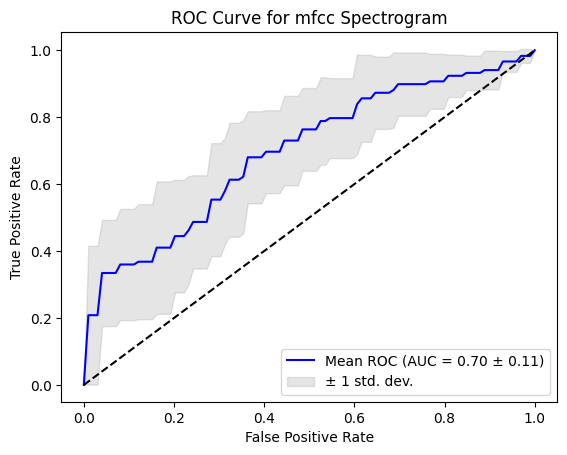


Mean and Std Dev of Performance Metrics for Spectrogram mfcc:
Fold                   3.000000
Accuracy              62.040816
F1 Score               0.611120
Precision              0.621756
Recall                 0.620408
Specificity            0.665538
Kappa                  0.234604
ROC AUC                0.697058
Training Time (s)    570.541987
Testing Time (s)       3.756003
dtype: float64
Fold                   1.581139
Accuracy               7.982697
F1 Score               0.090125
Precision              0.079800
Recall                 0.079827
Specificity            0.120892
Kappa                  0.167254
ROC AUC                0.126364
Training Time (s)    204.433876
Testing Time (s)       0.566865
dtype: float64


In [3]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, LeakyReLU, Multiply, Add, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['mfcc']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels


# Define the PSFAN model function
def PSFAN(input, num_classes):
    conv1 = Conv2D(32, (3, 3), dilation_rate=1, activation=LeakyReLU(alpha=0.02))(input)
    x = Conv2D(32, (1, 1), padding='same')(conv1)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a = Activation('sigmoid')(x)
    attention = Multiply()([a, conv1])
    add = Add()([x, attention])
    M = MaxPooling2D(pool_size=(3, 3), padding='valid')(add)
    F = Flatten()(M)

    conv2 = Conv2D(32, (3, 3), dilation_rate=2, activation=LeakyReLU(alpha=0.02))(conv1)
    x = Conv2D(32, (1, 1), padding='same')(conv2)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a1 = Activation('sigmoid')(x)
    attention1 = Multiply()([a1, conv2])
    add1 = Add()([x, attention1])
    M1 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add1)
    F1 = Flatten()(M1)

    conv3 = Conv2D(64, (3, 3), dilation_rate=3, activation=LeakyReLU(alpha=0.02))(conv2)
    x = Conv2D(64, (1, 1), padding='same')(conv3)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a2 = Activation('sigmoid')(x)
    attention2 = Multiply()([a2, conv3])
    add2 = Add()([x, attention2])
    M2 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add2)
    F2 = Flatten()(M2)

    conv4 = Conv2D(64, (3, 3), dilation_rate=4, activation=LeakyReLU(alpha=0.02))(conv3)
    x = Conv2D(64, (1, 1), padding='same')(conv4)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a3 = Activation('sigmoid')(x)
    attention3 = Multiply()([a3, conv4])
    add3 = Add()([x, attention3])
    M3 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add3)
    F3 = Flatten()(M3)

    C = Concatenate()([F, F1, F2, F3])

    D2 = Dense(128, activation=LeakyReLU(alpha=0.02))(C)
    D2 = Dense(64, activation=LeakyReLU(alpha=0.02))(D2)

    OUT = Dense(num_classes, activation='softmax')(D2)
    model = Model(inputs=[input], outputs=OUT, name="PSFANModel")
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    x, y = shuffle(img_data, labels, random_state=42)

    num_classes = 2
    input_shape = (128, 128, 3)
    input_layer = Input(shape=input_shape, name='input')
    model = PSFAN(input_layer, num_classes)

    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold_metrics = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for fold, (train_index, test_index) in enumerate(kfold.split(x, y), 1):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        y_train = to_categorical(y_train, num_classes)
        y_test = to_categorical(y_test, num_classes)

        model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), loss='binary_crossentropy', metrics=['accuracy'])
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Record training time
        start_train = time.time()
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1, callbacks=[early_stop])
        training_time = time.time() - start_train

        # Record testing time
        start_test = time.time()
        y_pred_prob = model.predict(X_test)
        testing_time = time.time() - start_test

        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_test, axis=1)

        # Calculate metrics
        accuracy = np.mean(y_pred == y_true) * 100
        f1 = f1_score(y_true, y_pred, average='weighted')
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        kappa = cohen_kappa_score(y_true, y_pred)

        # Specificity calculation
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        specificity = tn / (tn + fp)

        fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
        roc_auc = auc(fpr, tpr)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(roc_auc)

        fold_metrics.append({
            "Fold": fold,
            "Accuracy": accuracy,
            "F1 Score": f1,
            "Precision": precision,
            "Recall": recall,
            "Specificity": specificity,
            "Kappa": kappa,
            "ROC AUC": roc_auc,
            "Training Time (s)": training_time,
            "Testing Time (s)": testing_time
        })

        print(f"Fold {fold} Results: Accuracy={accuracy:.2f}%, F1={f1:.2f}, Precision={precision:.2f}, Recall={recall:.2f}, Specificity={specificity:.2f}, Kappa={kappa:.2f}, ROC AUC={roc_auc:.2f}")
        
    # Plot ROC Curve with mean and std deviation
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    std_tpr = np.std(tprs, axis=0)

    plt.figure()
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})')
    plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='grey', alpha=0.2, label='± 1 std. dev.')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram')
    plt.legend(loc="lower right")
    plt.show()

    # Display mean and std dev of other metrics
    metrics_df = pd.DataFrame(fold_metrics)
    mean_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print(f"\nMean and Std Dev of Performance Metrics for Spectrogram {spectrogram}:")
    print(mean_metrics)
    print(std_metrics)


Training model for spectrogram type: chroma
Epoch 1/50
13/13 [==============================] - 52s 4s/step - loss: 0.7896 - accuracy: 0.4541 - val_loss: 0.7050 - val_accuracy: 0.5306
Epoch 2/50
13/13 [==============================] - 48s 4s/step - loss: 0.6350 - accuracy: 0.7041 - val_loss: 0.7010 - val_accuracy: 0.5306
Epoch 3/50
13/13 [==============================] - 47s 4s/step - loss: 0.5776 - accuracy: 0.7449 - val_loss: 0.6745 - val_accuracy: 0.6327
Epoch 4/50
13/13 [==============================] - 48s 4s/step - loss: 0.4928 - accuracy: 0.8418 - val_loss: 0.7077 - val_accuracy: 0.5714
Epoch 5/50
13/13 [==============================] - 47s 4s/step - loss: 0.4474 - accuracy: 0.8214 - val_loss: 0.7408 - val_accuracy: 0.5714
Epoch 6/50
13/13 [==============================] - 47s 4s/step - loss: 0.3712 - accuracy: 0.8724 - val_loss: 0.7876 - val_accuracy: 0.6122
Epoch 7/50
13/13 [==============================] - 48s 4s/step - loss: 0.2921 - accuracy: 0.9184 - val_loss: 0.8614

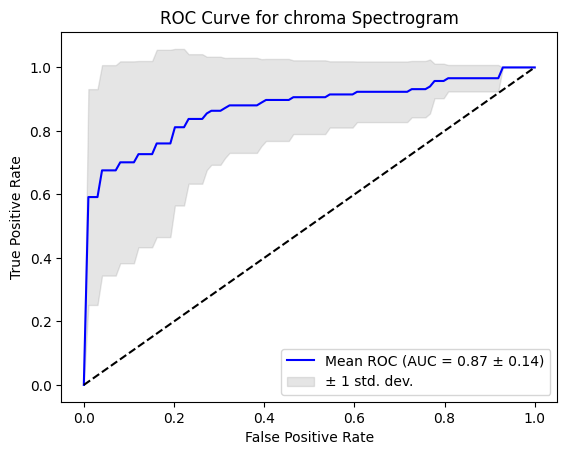


Mean and Std Dev of Performance Metrics for Spectrogram chroma:
Fold                   3.000000
Accuracy              79.591837
F1 Score               0.794779
Precision              0.803422
Recall                 0.795918
Specificity            0.779692
Kappa                  0.593659
ROC AUC                0.873428
Training Time (s)    316.438814
Testing Time (s)       3.266817
dtype: float64
Fold                  1.581139
Accuracy             13.147040
F1 Score              0.132460
Precision             0.129441
Recall                0.131470
Specificity           0.199462
Kappa                 0.259788
ROC AUC               0.158094
Training Time (s)    53.926746
Testing Time (s)      0.134757
dtype: float64


In [4]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, LeakyReLU, Multiply, Add, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['chroma']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels


# Define the PSFAN model function
def PSFAN(input, num_classes):
    conv1 = Conv2D(32, (3, 3), dilation_rate=1, activation=LeakyReLU(alpha=0.02))(input)
    x = Conv2D(32, (1, 1), padding='same')(conv1)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a = Activation('sigmoid')(x)
    attention = Multiply()([a, conv1])
    add = Add()([x, attention])
    M = MaxPooling2D(pool_size=(3, 3), padding='valid')(add)
    F = Flatten()(M)

    conv2 = Conv2D(32, (3, 3), dilation_rate=2, activation=LeakyReLU(alpha=0.02))(conv1)
    x = Conv2D(32, (1, 1), padding='same')(conv2)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a1 = Activation('sigmoid')(x)
    attention1 = Multiply()([a1, conv2])
    add1 = Add()([x, attention1])
    M1 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add1)
    F1 = Flatten()(M1)

    conv3 = Conv2D(64, (3, 3), dilation_rate=3, activation=LeakyReLU(alpha=0.02))(conv2)
    x = Conv2D(64, (1, 1), padding='same')(conv3)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a2 = Activation('sigmoid')(x)
    attention2 = Multiply()([a2, conv3])
    add2 = Add()([x, attention2])
    M2 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add2)
    F2 = Flatten()(M2)

    conv4 = Conv2D(64, (3, 3), dilation_rate=4, activation=LeakyReLU(alpha=0.02))(conv3)
    x = Conv2D(64, (1, 1), padding='same')(conv4)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a3 = Activation('sigmoid')(x)
    attention3 = Multiply()([a3, conv4])
    add3 = Add()([x, attention3])
    M3 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add3)
    F3 = Flatten()(M3)

    C = Concatenate()([F, F1, F2, F3])

    D2 = Dense(128, activation=LeakyReLU(alpha=0.02))(C)
    D2 = Dense(64, activation=LeakyReLU(alpha=0.02))(D2)

    OUT = Dense(num_classes, activation='softmax')(D2)
    model = Model(inputs=[input], outputs=OUT, name="PSFANModel")
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    x, y = shuffle(img_data, labels, random_state=42)

    num_classes = 2
    input_shape = (128, 128, 3)
    input_layer = Input(shape=input_shape, name='input')
    model = PSFAN(input_layer, num_classes)

    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold_metrics = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for fold, (train_index, test_index) in enumerate(kfold.split(x, y), 1):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        y_train = to_categorical(y_train, num_classes)
        y_test = to_categorical(y_test, num_classes)

        model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), loss='binary_crossentropy', metrics=['accuracy'])
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Record training time
        start_train = time.time()
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1, callbacks=[early_stop])
        training_time = time.time() - start_train

        # Record testing time
        start_test = time.time()
        y_pred_prob = model.predict(X_test)
        testing_time = time.time() - start_test

        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_test, axis=1)

        # Calculate metrics
        accuracy = np.mean(y_pred == y_true) * 100
        f1 = f1_score(y_true, y_pred, average='weighted')
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        kappa = cohen_kappa_score(y_true, y_pred)

        # Specificity calculation
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        specificity = tn / (tn + fp)

        fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
        roc_auc = auc(fpr, tpr)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(roc_auc)

        fold_metrics.append({
            "Fold": fold,
            "Accuracy": accuracy,
            "F1 Score": f1,
            "Precision": precision,
            "Recall": recall,
            "Specificity": specificity,
            "Kappa": kappa,
            "ROC AUC": roc_auc,
            "Training Time (s)": training_time,
            "Testing Time (s)": testing_time
        })

        print(f"Fold {fold} Results: Accuracy={accuracy:.2f}%, F1={f1:.2f}, Precision={precision:.2f}, Recall={recall:.2f}, Specificity={specificity:.2f}, Kappa={kappa:.2f}, ROC AUC={roc_auc:.2f}")
        
    # Plot ROC Curve with mean and std deviation
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    std_tpr = np.std(tprs, axis=0)

    plt.figure()
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})')
    plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='grey', alpha=0.2, label='± 1 std. dev.')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram')
    plt.legend(loc="lower right")
    plt.show()

    # Display mean and std dev of other metrics
    metrics_df = pd.DataFrame(fold_metrics)
    mean_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print(f"\nMean and Std Dev of Performance Metrics for Spectrogram {spectrogram}:")
    print(mean_metrics)
    print(std_metrics)


Training model for spectrogram type: cqt
Epoch 1/50
13/13 [==============================] - 54s 4s/step - loss: 0.8232 - accuracy: 0.4643 - val_loss: 0.6990 - val_accuracy: 0.5510
Epoch 2/50
13/13 [==============================] - 50s 4s/step - loss: 0.6973 - accuracy: 0.5255 - val_loss: 0.6943 - val_accuracy: 0.5306
Epoch 3/50
13/13 [==============================] - 49s 4s/step - loss: 0.6824 - accuracy: 0.5255 - val_loss: 0.6953 - val_accuracy: 0.4490
Epoch 4/50
13/13 [==============================] - 50s 4s/step - loss: 0.6530 - accuracy: 0.7041 - val_loss: 0.6979 - val_accuracy: 0.4694
Epoch 5/50
13/13 [==============================] - 50s 4s/step - loss: 0.6426 - accuracy: 0.6633 - val_loss: 0.7036 - val_accuracy: 0.5918
Epoch 6/50
13/13 [==============================] - 50s 4s/step - loss: 0.6188 - accuracy: 0.7092 - val_loss: 0.7060 - val_accuracy: 0.5714
Epoch 7/50
2/2 [==============================] - 3s 867ms/step
Fold 1 Results: Accuracy=53.06%, F1=0.52, Precision=0.5

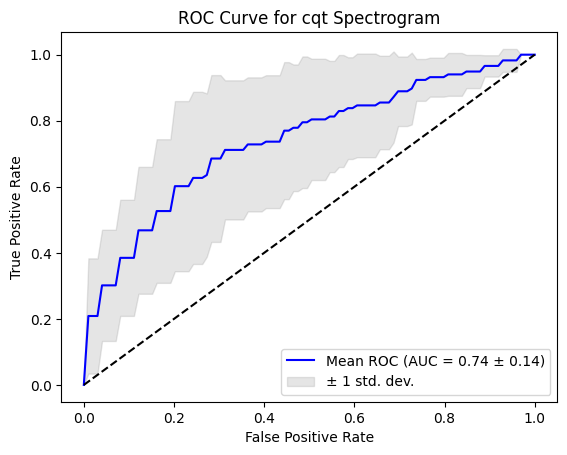


Mean and Std Dev of Performance Metrics for Spectrogram cqt:
Fold                   3.000000
Accuracy              66.122449
F1 Score               0.643883
Precision              0.687696
Recall                 0.661224
Specificity            0.650769
Kappa                  0.320908
ROC AUC                0.739001
Training Time (s)    343.090481
Testing Time (s)       3.511421
dtype: float64
Fold                  1.581139
Accuracy             11.688017
F1 Score              0.134252
Precision             0.110098
Recall                0.116880
Specificity           0.265900
Kappa                 0.235369
ROC AUC               0.159757
Training Time (s)    38.728049
Testing Time (s)      0.620705
dtype: float64


In [5]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, LeakyReLU, Multiply, Add, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['cqt']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels


# Define the PSFAN model function
def PSFAN(input, num_classes):
    conv1 = Conv2D(32, (3, 3), dilation_rate=1, activation=LeakyReLU(alpha=0.02))(input)
    x = Conv2D(32, (1, 1), padding='same')(conv1)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a = Activation('sigmoid')(x)
    attention = Multiply()([a, conv1])
    add = Add()([x, attention])
    M = MaxPooling2D(pool_size=(3, 3), padding='valid')(add)
    F = Flatten()(M)

    conv2 = Conv2D(32, (3, 3), dilation_rate=2, activation=LeakyReLU(alpha=0.02))(conv1)
    x = Conv2D(32, (1, 1), padding='same')(conv2)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a1 = Activation('sigmoid')(x)
    attention1 = Multiply()([a1, conv2])
    add1 = Add()([x, attention1])
    M1 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add1)
    F1 = Flatten()(M1)

    conv3 = Conv2D(64, (3, 3), dilation_rate=3, activation=LeakyReLU(alpha=0.02))(conv2)
    x = Conv2D(64, (1, 1), padding='same')(conv3)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a2 = Activation('sigmoid')(x)
    attention2 = Multiply()([a2, conv3])
    add2 = Add()([x, attention2])
    M2 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add2)
    F2 = Flatten()(M2)

    conv4 = Conv2D(64, (3, 3), dilation_rate=4, activation=LeakyReLU(alpha=0.02))(conv3)
    x = Conv2D(64, (1, 1), padding='same')(conv4)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a3 = Activation('sigmoid')(x)
    attention3 = Multiply()([a3, conv4])
    add3 = Add()([x, attention3])
    M3 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add3)
    F3 = Flatten()(M3)

    C = Concatenate()([F, F1, F2, F3])

    D2 = Dense(128, activation=LeakyReLU(alpha=0.02))(C)
    D2 = Dense(64, activation=LeakyReLU(alpha=0.02))(D2)

    OUT = Dense(num_classes, activation='softmax')(D2)
    model = Model(inputs=[input], outputs=OUT, name="PSFANModel")
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    x, y = shuffle(img_data, labels, random_state=42)

    num_classes = 2
    input_shape = (128, 128, 3)
    input_layer = Input(shape=input_shape, name='input')
    model = PSFAN(input_layer, num_classes)

    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold_metrics = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for fold, (train_index, test_index) in enumerate(kfold.split(x, y), 1):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        y_train = to_categorical(y_train, num_classes)
        y_test = to_categorical(y_test, num_classes)

        model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), loss='binary_crossentropy', metrics=['accuracy'])
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Record training time
        start_train = time.time()
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1, callbacks=[early_stop])
        training_time = time.time() - start_train

        # Record testing time
        start_test = time.time()
        y_pred_prob = model.predict(X_test)
        testing_time = time.time() - start_test

        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_test, axis=1)

        # Calculate metrics
        accuracy = np.mean(y_pred == y_true) * 100
        f1 = f1_score(y_true, y_pred, average='weighted')
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        kappa = cohen_kappa_score(y_true, y_pred)

        # Specificity calculation
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        specificity = tn / (tn + fp)

        fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
        roc_auc = auc(fpr, tpr)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(roc_auc)

        fold_metrics.append({
            "Fold": fold,
            "Accuracy": accuracy,
            "F1 Score": f1,
            "Precision": precision,
            "Recall": recall,
            "Specificity": specificity,
            "Kappa": kappa,
            "ROC AUC": roc_auc,
            "Training Time (s)": training_time,
            "Testing Time (s)": testing_time
        })

        print(f"Fold {fold} Results: Accuracy={accuracy:.2f}%, F1={f1:.2f}, Precision={precision:.2f}, Recall={recall:.2f}, Specificity={specificity:.2f}, Kappa={kappa:.2f}, ROC AUC={roc_auc:.2f}")
        
    # Plot ROC Curve with mean and std deviation
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    std_tpr = np.std(tprs, axis=0)

    plt.figure()
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})')
    plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='grey', alpha=0.2, label='± 1 std. dev.')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram')
    plt.legend(loc="lower right")
    plt.show()

    # Display mean and std dev of other metrics
    metrics_df = pd.DataFrame(fold_metrics)
    mean_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print(f"\nMean and Std Dev of Performance Metrics for Spectrogram {spectrogram}:")
    print(mean_metrics)
    print(std_metrics)


Training model for spectrogram type: mel
Epoch 1/50
13/13 [==============================] - 79s 6s/step - loss: 0.7880 - accuracy: 0.4745 - val_loss: 0.7078 - val_accuracy: 0.5102
Epoch 2/50
13/13 [==============================] - 74s 6s/step - loss: 0.7005 - accuracy: 0.5306 - val_loss: 0.6926 - val_accuracy: 0.4694
Epoch 3/50
13/13 [==============================] - 74s 6s/step - loss: 0.6689 - accuracy: 0.6276 - val_loss: 0.6899 - val_accuracy: 0.5102
Epoch 4/50
13/13 [==============================] - 75s 6s/step - loss: 0.6264 - accuracy: 0.6684 - val_loss: 0.7955 - val_accuracy: 0.5306
Epoch 5/50
13/13 [==============================] - 75s 6s/step - loss: 0.6095 - accuracy: 0.6480 - val_loss: 0.7063 - val_accuracy: 0.5102
Epoch 6/50
13/13 [==============================] - 75s 6s/step - loss: 0.5802 - accuracy: 0.6888 - val_loss: 0.7421 - val_accuracy: 0.5102
Epoch 7/50
13/13 [==============================] - 75s 6s/step - loss: 0.5114 - accuracy: 0.7551 - val_loss: 0.8282 - 

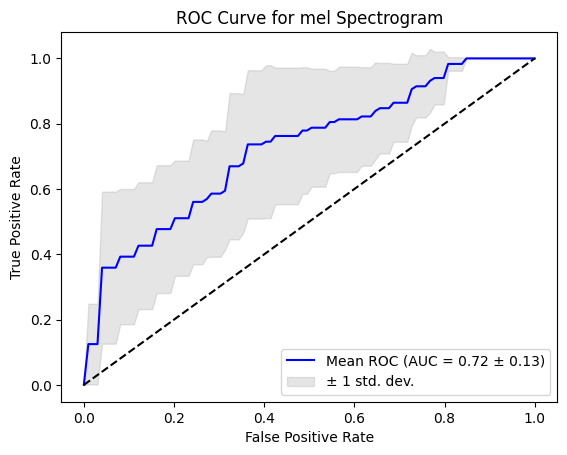


Mean and Std Dev of Performance Metrics for Spectrogram mel:
Fold                   3.000000
Accuracy              66.530612
F1 Score               0.661033
Precision              0.682609
Recall                 0.665306
Specificity            0.668000
Kappa                  0.330741
ROC AUC                0.724688
Training Time (s)    523.453879
Testing Time (s)       4.654538
dtype: float64
Fold                  1.581139
Accuracy             12.125266
F1 Score              0.118513
Precision             0.133648
Recall                0.121253
Specificity           0.192666
Kappa                 0.241933
ROC AUC               0.148852
Training Time (s)    59.152735
Testing Time (s)      0.485205
dtype: float64


In [6]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, LeakyReLU, Multiply, Add, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['mel']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels


# Define the PSFAN model function
def PSFAN(input, num_classes):
    conv1 = Conv2D(32, (3, 3), dilation_rate=1, activation=LeakyReLU(alpha=0.02))(input)
    x = Conv2D(32, (1, 1), padding='same')(conv1)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a = Activation('sigmoid')(x)
    attention = Multiply()([a, conv1])
    add = Add()([x, attention])
    M = MaxPooling2D(pool_size=(3, 3), padding='valid')(add)
    F = Flatten()(M)

    conv2 = Conv2D(32, (3, 3), dilation_rate=2, activation=LeakyReLU(alpha=0.02))(conv1)
    x = Conv2D(32, (1, 1), padding='same')(conv2)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a1 = Activation('sigmoid')(x)
    attention1 = Multiply()([a1, conv2])
    add1 = Add()([x, attention1])
    M1 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add1)
    F1 = Flatten()(M1)

    conv3 = Conv2D(64, (3, 3), dilation_rate=3, activation=LeakyReLU(alpha=0.02))(conv2)
    x = Conv2D(64, (1, 1), padding='same')(conv3)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a2 = Activation('sigmoid')(x)
    attention2 = Multiply()([a2, conv3])
    add2 = Add()([x, attention2])
    M2 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add2)
    F2 = Flatten()(M2)

    conv4 = Conv2D(64, (3, 3), dilation_rate=4, activation=LeakyReLU(alpha=0.02))(conv3)
    x = Conv2D(64, (1, 1), padding='same')(conv4)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a3 = Activation('sigmoid')(x)
    attention3 = Multiply()([a3, conv4])
    add3 = Add()([x, attention3])
    M3 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add3)
    F3 = Flatten()(M3)

    C = Concatenate()([F, F1, F2, F3])

    D2 = Dense(128, activation=LeakyReLU(alpha=0.02))(C)
    D2 = Dense(64, activation=LeakyReLU(alpha=0.02))(D2)

    OUT = Dense(num_classes, activation='softmax')(D2)
    model = Model(inputs=[input], outputs=OUT, name="PSFANModel")
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    x, y = shuffle(img_data, labels, random_state=42)

    num_classes = 2
    input_shape = (128, 128, 3)
    input_layer = Input(shape=input_shape, name='input')
    model = PSFAN(input_layer, num_classes)

    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold_metrics = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for fold, (train_index, test_index) in enumerate(kfold.split(x, y), 1):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        y_train = to_categorical(y_train, num_classes)
        y_test = to_categorical(y_test, num_classes)

        model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), loss='binary_crossentropy', metrics=['accuracy'])
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Record training time
        start_train = time.time()
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1, callbacks=[early_stop])
        training_time = time.time() - start_train

        # Record testing time
        start_test = time.time()
        y_pred_prob = model.predict(X_test)
        testing_time = time.time() - start_test

        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_test, axis=1)

        # Calculate metrics
        accuracy = np.mean(y_pred == y_true) * 100
        f1 = f1_score(y_true, y_pred, average='weighted')
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        kappa = cohen_kappa_score(y_true, y_pred)

        # Specificity calculation
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        specificity = tn / (tn + fp)

        fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
        roc_auc = auc(fpr, tpr)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(roc_auc)

        fold_metrics.append({
            "Fold": fold,
            "Accuracy": accuracy,
            "F1 Score": f1,
            "Precision": precision,
            "Recall": recall,
            "Specificity": specificity,
            "Kappa": kappa,
            "ROC AUC": roc_auc,
            "Training Time (s)": training_time,
            "Testing Time (s)": testing_time
        })

        print(f"Fold {fold} Results: Accuracy={accuracy:.2f}%, F1={f1:.2f}, Precision={precision:.2f}, Recall={recall:.2f}, Specificity={specificity:.2f}, Kappa={kappa:.2f}, ROC AUC={roc_auc:.2f}")
        
    # Plot ROC Curve with mean and std deviation
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    std_tpr = np.std(tprs, axis=0)

    plt.figure()
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})')
    plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='grey', alpha=0.2, label='± 1 std. dev.')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram')
    plt.legend(loc="lower right")
    plt.show()

    # Display mean and std dev of other metrics
    metrics_df = pd.DataFrame(fold_metrics)
    mean_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print(f"\nMean and Std Dev of Performance Metrics for Spectrogram {spectrogram}:")
    print(mean_metrics)
    print(std_metrics)
